In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Load your GeoPackage with tree locations
gdf = gpd.read_file('output.gpkg')

# Function to load prediction and extract max in a local window
def extract_predictions_for_image(image_id, window_size=1):
    npy_path = f'Inference output/heights_{image_id}.npy'
    try:
        prediction_array = np.load(npy_path)
    except FileNotFoundError:
        print(f"Prediction file not found for {image_id}")
        return None

    image_rows = gdf[gdf['image'] == f'{image_id}.png'].copy()
    predictions = []

    for idx, row in image_rows.iterrows():
        x, y = int(round(row['px'])), int(round(row['py']))

        # Extract local window boundaries
        x_min = max(0, x - window_size)
        x_max = min(prediction_array.shape[1], x + window_size + 1)
        y_min = max(0, y - window_size)
        y_max = min(prediction_array.shape[0], y + window_size + 1)

        # Extract window and find max
        local_window = prediction_array[y_min:y_max, x_min:x_max]

        if local_window.size > 0:
            predicted_value = np.nanmax(local_window)
        else:
            predicted_value = np.nan

        predictions.append(predicted_value)

    image_rows['Predicted'] = predictions
    return image_rows.dropna(subset=['Predicted'])

# Process all unique images with window-based sampling
results = []
for image_id in gdf['image'].str.replace('.png', '').unique():
    result = extract_predictions_for_image(image_id, window_size=10)  # Change window_size as needed
    if result is not None:
        results.append(result)

# Combine all into a single DataFrame
if results:
    all_results = pd.concat(results, ignore_index=True)
    print(all_results.head())
else:
    print("No data matched.")


        ID                Date  Height   Species     image          px  \
0  3296001 2023-08-24 18:23:02    4.30  Ilmbjörk  3296.png  120.985212   
1  3296003 2023-08-24 18:23:02    5.30  Ilmbjörk  3296.png  123.437114   
2  3296005 2023-08-24 18:23:02    3.80  Ilmbjörk  3296.png  124.501909   
3  3296006 2023-08-24 18:23:02    5.21  Ilmbjörk  3296.png  124.443830   
4  3296007 2023-08-24 18:23:02    7.44  Ilmbjörk  3296.png  133.617409   

           py                                geometry  Predicted  
0  121.801100  POINT Z (-19.49256 63.52876 103.93267)   2.381585  
1  124.475135  POINT Z (-19.49254 63.52874 102.90667)   2.381585  
2  125.320163  POINT Z (-19.49253 63.52874 102.58067)   2.381585  
3  126.280853  POINT Z (-19.49253 63.52874 102.30167)   2.381585  
4  126.983857  POINT Z (-19.49243 63.52873 102.78767)   3.558133  


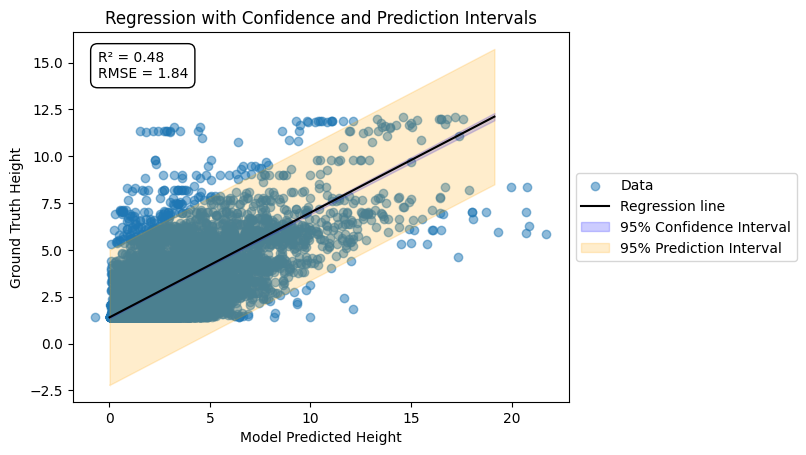

In [26]:
import matplotlib.pyplot as plt
from scipy import stats

# Filter out invalid data
clean_results = all_results.dropna(subset=['Height', 'Predicted'])
X = clean_results[['Predicted']].values
y = clean_results['Height'].values

# Fit regression model
model = LinearRegression()
model.fit(X, y)

def compute_intervals(X, y, model, confidence=0.95):
    X_sorted = np.sort(X.flatten())
    y_pred = model.predict(X_sorted.reshape(-1, 1))
    n = len(X)
    mean_x = np.mean(X)
    t_value = stats.t.ppf((1 + confidence) / 2., n - 2)
    s_err = np.sqrt(np.sum((y - model.predict(X)) ** 2) / (n - 2))
    confs = t_value * s_err * np.sqrt(1/n + (X_sorted - mean_x)**2 / np.sum((X - mean_x)**2))
    preds = t_value * s_err * np.sqrt(1 + 1/n + (X_sorted - mean_x)**2 / np.sum((X - mean_x)**2))
    return X_sorted, y_pred, confs, preds

# Compute intervals
X_sorted, y_pred_sorted, confs, preds = compute_intervals(X, y, model)

# Metrics
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Plot
plt.scatter(y, y_pred, alpha=0.5, label='Data')
plt.plot(X_sorted, y_pred_sorted, color='black', label='Regression line')
plt.fill_between(X_sorted, y_pred_sorted - confs, y_pred_sorted + confs, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.fill_between(X_sorted, y_pred_sorted - preds, y_pred_sorted + preds, color='orange', alpha=0.2, label='95% Prediction Interval')
plt.text(0.05, 0.95, f'R² = {r2:.2f}\nRMSE = {rmse:.2f}', transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Model Predicted Height')
plt.ylabel('Ground Truth Height')
plt.title('Regression with Confidence and Prediction Intervals')
plt.show()
